In [1]:
import pandas as pd
import random

# read original dataset
student_df = pd.read_csv('students.csv')

# filter the students who are graduated
graduated_student_df = student_df[student_df['graduated'] == 1]

# random sample for 500 students 
unique_student_id = list(graduated_student_df['stud.id'].unique())
random.seed(30) # set a seed so that everytime we will extract same sample
sample_student_id = random.sample(unique_student_id, 500)
sample_df = graduated_student_df[graduated_student_df['stud.id'].isin(sample_student_id)].reset_index(drop=True)

# two variables of interest
sample_df = sample_df[['major', 'salary']]
groups = sample_df.groupby('major').count().reset_index()
# groups.plot(kind='bar',x='major',y='salary')
groups

,major,salary
0,Biology,87
1,Economics and Finance,94
2,Environmental Sciences,97
3,Mathematics and Statistics,75
4,Political Science,84
5,Social Sciences,63


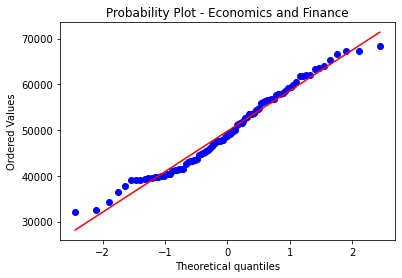

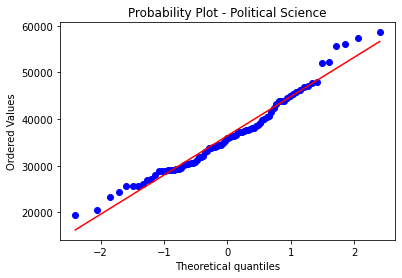

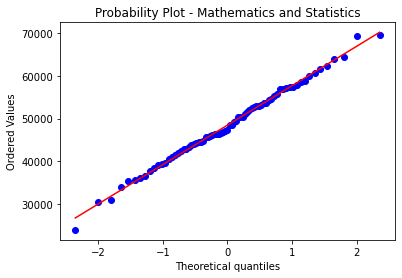

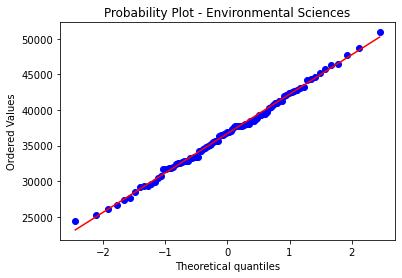

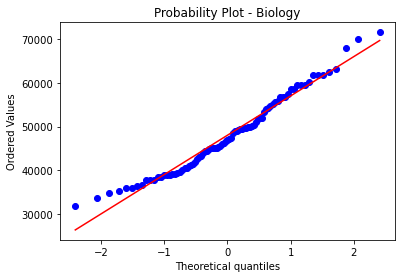

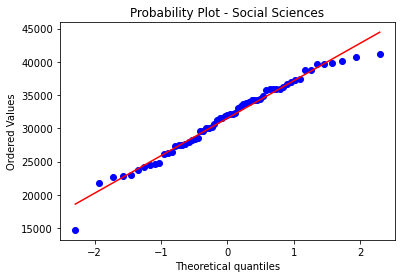

In [2]:
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt

unique_majors = sample_df['major'].unique()
for major in unique_majors:
    stats.probplot(sample_df[sample_df['major'] == major]['salary'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  major)
    plt.show()

In [3]:
ratio = sample_df.groupby('major').std().max() / sample_df.groupby('major').std().min()
ratio

salary    1.669921
dtype: float64

In [4]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = sample_df['salary'].mean()
SSTR = sample_df.groupby('major').count() * (sample_df.groupby('major').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['salary'].sum()

# calculate SSE and update anova table
SSE = (sample_df.groupby('major').count() - 1) * sample_df.groupby('major').std()**2
anova_table['SS']['Within Groups'] = SSE['salary'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['salary'].sum() + SSE['salary'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = sample_df['major'].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df['major'].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,24184075535.074078,5,4836815107.014815,77.408037,0.0,2.592178
Within Groups,30867423591.219269,494,62484663.14012,,,
Total,55051499126.29335,499,110323645.543674,,,


In [5]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and critical value is:", anova_table['F crit']['Between Groups'])
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 77.40803685167356  and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
F-score is: 77.40803685167356  and critical value is: 2.592178494905
Null Hypothesis is rejected.
